In [51]:
import pandas as pd

df = pd.read_csv('data/seniority-level.csv')

In [52]:
df.dropna(axis=0, inplace=True)

In [53]:
df.head()

,jobtitle,link,summary,description,Seniority
0,Einkäufer (w/m/d),https://www.roberthalf.de/job/munchen/einkaufe...,Einkäufer (w/m/d) gesucht - Für unseren Kunden...,"<div class=""rh-job-page__job-info-text""><p><st...",Medior
1,Bilanzbuchhalter (w/m/d),https://www.roberthalf.de/job/essen/bilanzbuch...,Bilanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Senior
2,Bilanzbuchhalter (w/m/d),https://www.roberthalf.de/job/duisburg/bilanzb...,Bilanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Senior
3,Finanzbuchhalter (w/m/d),https://www.roberthalf.de/job/unna/finanzbuchh...,Finanzbuchhalter (w/m/d) gesucht - Für unseren...,"<div class=""rh-job-page__job-info-text""><p><st...",Medior
4,Sachbearbeiter Logistik (w/m/d),https://www.roberthalf.de/job/worms/sachbearbe...,Sachbearbeiter Logistik (w/m/d) gesucht - Für ...,"<div class=""rh-job-page__job-info-text""><p><st...",Junior


In [54]:
df.shape

(140, 5)

In [55]:
df_jf = pd.read_csv('data/seniority-level-jf.csv')

In [56]:
df_jf.dropna(axis=0, inplace=True)

In [57]:
df_jf.head()

,filename,vac_title,fulltext,Seniority
0,file:/home/dehling/Downloads/jf_data_de/jf_dat...,Praktikant IT-Entwicklung - Projekt Industrie ...,Praktikant IT-Entwicklung - Projekt Industrie ...,Junior
1,file:/home/dehling/Downloads/jf_data_de/jf_dat...,Assistenzärzte (m/w) für ein Ausbildungscurric...,assistenzärzte (m/w) für ein ausbildungscurric...,Medior
2,file:/home/dehling/Downloads/jf_data_de/jf_dat...,Koch (m/w),Das Sylter Stadtgeflüster ist eine Genussoase ...,Medior
3,file:/home/dehling/Downloads/jf_data_de/jf_dat...,"Fachinformatiker/in, Systemintegration","Fachinformatiker/in, Systemintegration ?% Eign...",Junior
4,file:/home/dehling/Downloads/jf_data_de/jf_dat...,Praktikum im Spezialtiefbau - Bauingenieurwesen,Praktikum im Spezialtiefbau - Bauingenieurwese...,Junior


In [58]:
df_jf.shape

(139, 4)

In [78]:
from gensim.parsing.preprocessing import preprocess_string, RE_TAGS, strip_punctuation, \
    strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short, stem_text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD


def my_remove_tags(s):
    return RE_TAGS.sub(" ", s)

my_filters = [
    lambda x: x.lower(), my_remove_tags, strip_punctuation,
    strip_multiple_whitespaces, strip_numeric,
    remove_stopwords, strip_short, stem_text
]

def my_tokenizer(s):
    return preprocess_string(s, my_filters)
    
vect = CountVectorizer(min_df=10, max_df=0.33, strip_accents='unicode', analyzer='word',
                       tokenizer=my_tokenizer, ngram_range=(1,2))

le = LabelEncoder()

X = vect.fit_transform(df['description'].tolist() + df_jf['fulltext'].tolist())
y = le.fit_transform(df['Seniority'].tolist() + df_jf['Seniority'].tolist())

scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)

svd = TruncatedSVD(n_components=250)
X_lsa = svd.fit_transform(X)

In [79]:
X.shape

(279, 783)

In [80]:
X_lsa.shape

(279, 250)

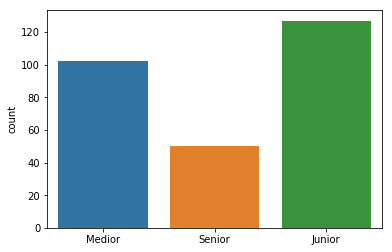

In [62]:
import seaborn as sns
%matplotlib inline

ax = sns.countplot(x=(df['Seniority'].tolist() + df_jf['Seniority'].tolist()))

In [82]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')
print("Log loss: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.4692 (+/- 0.0568)
F1: 0.4369 (+/- 0.0494)
Log loss: -4.3295 (+/- 1.2246)


In [84]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='auto')

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')
print("Log loss: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.5627 (+/- 0.0324)
F1: 0.5451 (+/- 0.0703)
Log loss: -1.2153 (+/- 0.2192)


In [68]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='auto')

scores = cross_val_score(clf, X_lsa, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X_lsa, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X_lsa, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')
print("Log loss: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.5552 (+/- 0.0233)
F1: 0.5379 (+/- 0.0568)
Log loss: -1.1774 (+/- 0.1472)


In [86]:
from sklearn.svm import SVC, LinearSVC

#clf = LinearSVC()
clf = SVC(kernel='linear', probability=True)


scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')
print("Log loss: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.5518 (+/- 0.0385)
F1: 0.5302 (+/- 0.0614)
Log loss: -0.9194 (+/- 0.0509)


In [87]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='accuracy')
print("Accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro')
print("F1: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='neg_log_loss')
print("Log loss: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Accuracy: 0.4762 (+/- 0.0578)
F1: 0.3626 (+/- 0.0700)
Log loss: -4.0760 (+/- 0.7653)


/home/dehling/Documents/machine-learnings/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [136]:
from sklearn.model_selection import train_test_split

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

#clf = MultinomialNB()
clf = LogisticRegression(solver='sag', multi_class='auto')
#clf = LinearSVC()
clf.fit(Xtr, ytr)

/home/dehling/Documents/machine-learnings/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [113]:
Xtr.shape

(223, 783)

In [114]:
Xte.shape

(56, 783)

In [137]:
from sklearn.metrics import classification_report

ypred = clf.predict(Xte)

print(classification_report(yte, ypred, target_names=le.classes_))

              precision    recall  f1-score   support

      Junior       0.69      0.69      0.69        26
      Medior       0.59      0.65      0.62        20
      Senior       0.62      0.50      0.56        10

   micro avg       0.64      0.64      0.64        56
   macro avg       0.64      0.61      0.62        56
weighted avg       0.64      0.64      0.64        56



In [75]:
le.classes_

array(['Junior', 'Medior', 'Senior'], dtype='<U6')

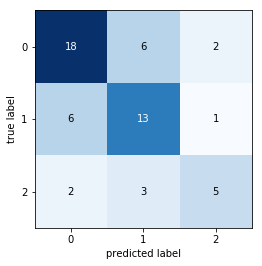

In [138]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(confusion_matrix(yte, ypred))

In [139]:
import numpy as np

feature_names = vect.get_feature_names()
for i, class_label in enumerate(le.classes_):
    top10 = np.argsort(clf.coef_[i])[-20:]
    print("%s: %s" % (class_label, ", ".join(feature_names[j] for j in top10)))
    print()

Junior: ihnen herr, erst erfahrung, kundenbetreuung, ausbildung oder, moglich, anwendungen, arbeiten, von vorteil, wir bieten, bieten, tatigkeiten, vorteil, zuverlassig, such, region, umgang, erst berufserfahrung, umgang mit, servic, erst

Medior: arbeitszeiten, klass, sie arbeiten, hat, verstarkung, sehr, profil erfolgreich, berufserfahrung der, der buchhaltung, produkt, altersvorsorg, weiterbildungsmoglichkeiten, bearbeitung, mitarbeit, team, stuttgart, wir suchen, gmbh, wunschenswert, durchfuhrung

Senior: oder vergleichbar, buchhaltung, bzw, anderen, develop, fundiert kenntniss, planung und, art, eigenverantwortlich, ort, weiterentwicklung, fundiert, nach hgb, al mitarbeit, sie un, hgb, durch, einschlagig, control, mehrjahrig

